Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [ ]:
# import packages here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jupyter_black

jupyter_black.load()

## Context
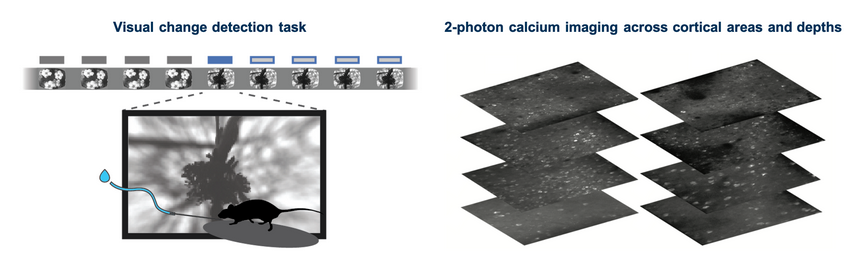

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

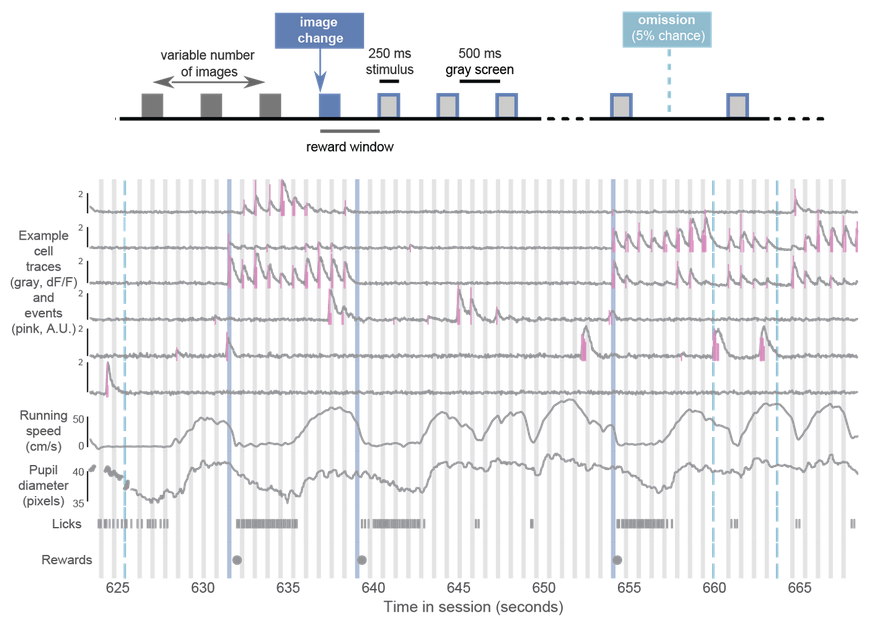

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [ ]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(
        data, "stim_epoch_table", ["stimulus", "start", "end"]
    )  # NOTE had to rearrange this, as the original order was wrong

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



Was ich hier raus lese:
- wir haben 105968 Zeitpunkte, von denen müssen aber nicht alle berücksichtigt werden weil wohl auch andere Sachen gemessen wurden 
- wir haben 189 Zellen die wir beobachten. Diese wurden genetisch modifziert, sodass sie auf den GCaMP6f Indicator reagieren. Das ist der schnelle Calcium Indikator den wir in VL 3 besprochen haben
- für jede dieser Zellen gibt es eine Region of Intereset
- es gibt eine running speed für jeden Zeitpunkt

### Fragen:
Hier würde ich mal offene Fragen sammeln, die wir im Tut stellen wollen oder uns gegenseitig beantworten können.

- OOPSI erlaubt?
- Running Speed relevant?
- was wurde gepreprocessed?
- Ist das Ziel die RFs spatially mit den ROIs der einzelnen Zellen zu mappen?

## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

### Erstes Drama: Plotting, um die Daten besser zu verstehen. 
Ich würde sagen es ist sinnvoll, folgende Plots einmal selbst zu machen:

- Time + Activity traces für 5 Zellen ( + Pupil / Running für den geplotteten Zeitabschnitt) (wie oben einfach zum nachvollziehen)
- ROI für 5 Zellen (die selben wie oben idealerweise) - das sollten Bilder sein, oder? Einfach nebeneinander plotten i guess?
- ROI Max (sollte ein Bild sein, oder? Schwarz weiß?)

- Die Stimuli und wie sie sich verändern; da ich die Stimuli noch nicht ganz verstanden hab, kann ich nicht so genau sagen was hier sinnvoll wäre...

by the way sehr nice musik: https://www.youtube.com/watch?v=rSDoXnslLsg

In [ ]:
print_info(data)

[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



t[:10]:  [9.33015 9.36332 9.39649 9.42967 9.46284 9.49601 9.52918 9.56235 9.59552
 9.6287 ]
t[-1]:  3524.5851
running_speed dim 0:  [nan nan nan nan nan nan nan nan nan nan]
running_speed dim 1:  [9.33015 9.36332 9.39649 9.42967 9.46284 9.49601 9.52918 9.56235 9.59552
 9.6287 ]
t and running_speed[1] are the same
first 10 indices of not NaN values:  [134 135 136 137 138 139 140 141 142 143]
time point of first not NaN value: 13.77516 ms


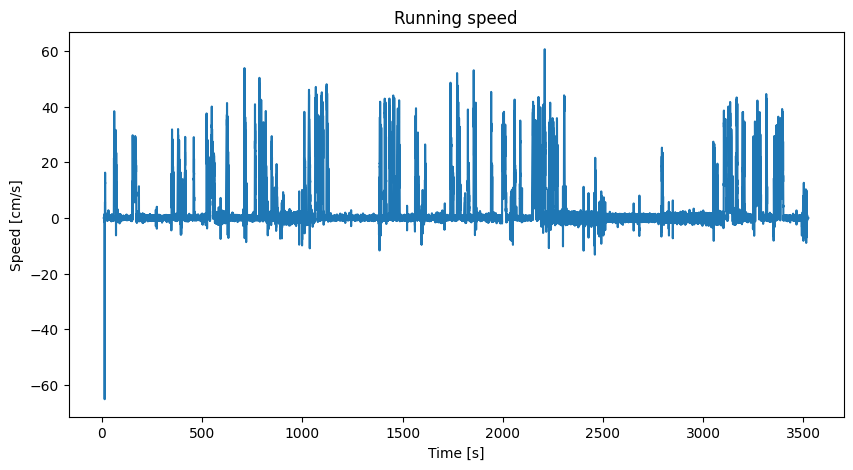

In [ ]:
# TODO: aufi plotti

# lets have a look at the time series
t = data["t"]
print("t[:10]: ", t[:10])
print("t[-1]: ", t[-1])
# NOTE okay, this are time points again, i guess in s?

# lets have a look at the running_speed
running_speed = data["running_speed"]
print("running_speed dim 0: ", running_speed[0][:10])  # speed in cm/s
print("running_speed dim 1: ", running_speed[1][:10])  # time in s
# NOTE the first array appears to be a measurement at each time point (second array)
# lots of NaNs in the measurement array -> should correct this by setting them to 0?
# check if t and running_speed[1] are the same
if np.array_equal(t, running_speed[1]):
    print("t and running_speed[1] are the same")
# replace NaNs with 0
running_speed_corrected = np.nan_to_num(running_speed[0], nan=0)

# another check: return indices of not NaN values
idx_not_nan = np.where(~np.isnan(running_speed[0]))[0]
print("first 10 indices of not NaN values: ", idx_not_nan[:10])
print(f"time point of first not NaN value: {running_speed[1][idx_not_nan[0]]} ms")
first_not_nan = running_speed[1][idx_not_nan[0]]
first_not_nan_idx = idx_not_nan[0]

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(
    t, running_speed_corrected
)  # matplotlib handles NaNs by replacing them with 0, so running_speed would suffice
axs.set_title("Running speed")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Speed [cm/s]")
plt.show()

dff cell 0:  [ 0.18523291  0.22521365  0.15662627  0.19827017  0.17344517  0.13762578
  0.13839774  0.10576149  0.05500292 -0.01929816]


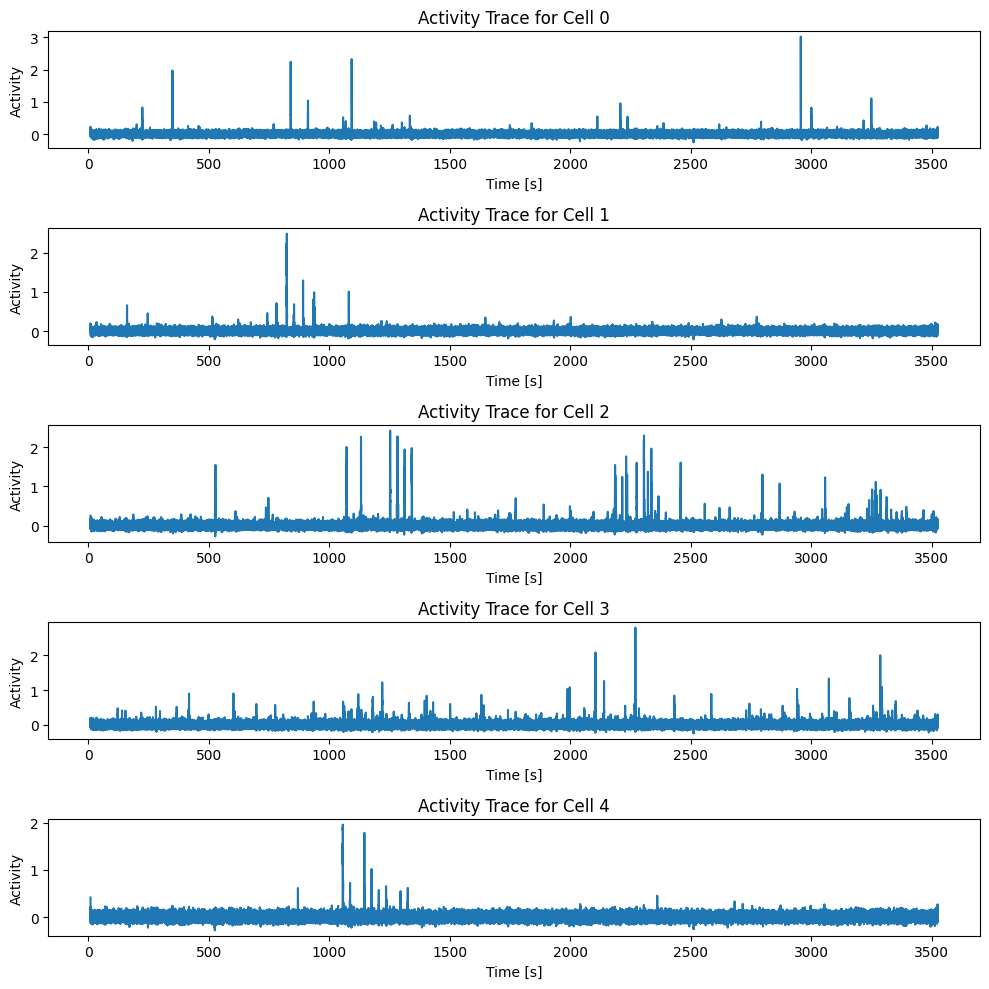

In [ ]:
# so now lets check out the activity traces for some cells
dff = data["dff"]
print("dff cell 0: ", dff[0][:10])  # NOTE what unit is this?

# print a activity trace for the first 5 cells
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for i in range(5):
    axs[i].plot(t, dff[i])
    axs[i].set_title(f"Activity Trace for Cell {i}")
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Activity")

plt.tight_layout()
plt.show()

# NOTE i think we should filter this

roi_masks shape:  (189, 512, 512)
roi_masks[0] max:  1


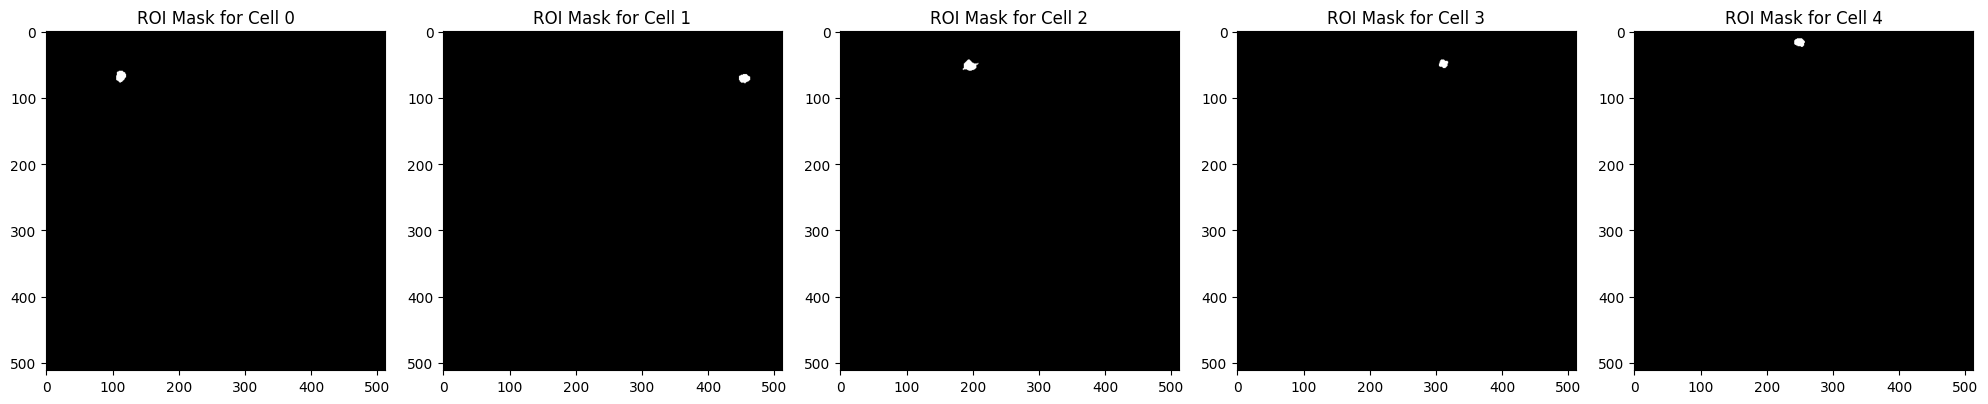

In [ ]:
# lets have a look at the ROI masks of the cells
roi_masks = data["roi_masks"]
print("roi_masks shape: ", roi_masks.shape)  # NOTE this is an image per cell
print("roi_masks[0] max: ", np.max(roi_masks[0]))  # Values are from 0 to 1

# lets plot the masks of the first 3 cells
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(roi_masks[i], cmap="gray")
    axs[i].set_title(f"ROI Mask for Cell {i}")

plt.tight_layout()
plt.show()

max_projection min:  93
max_projection max:  3558


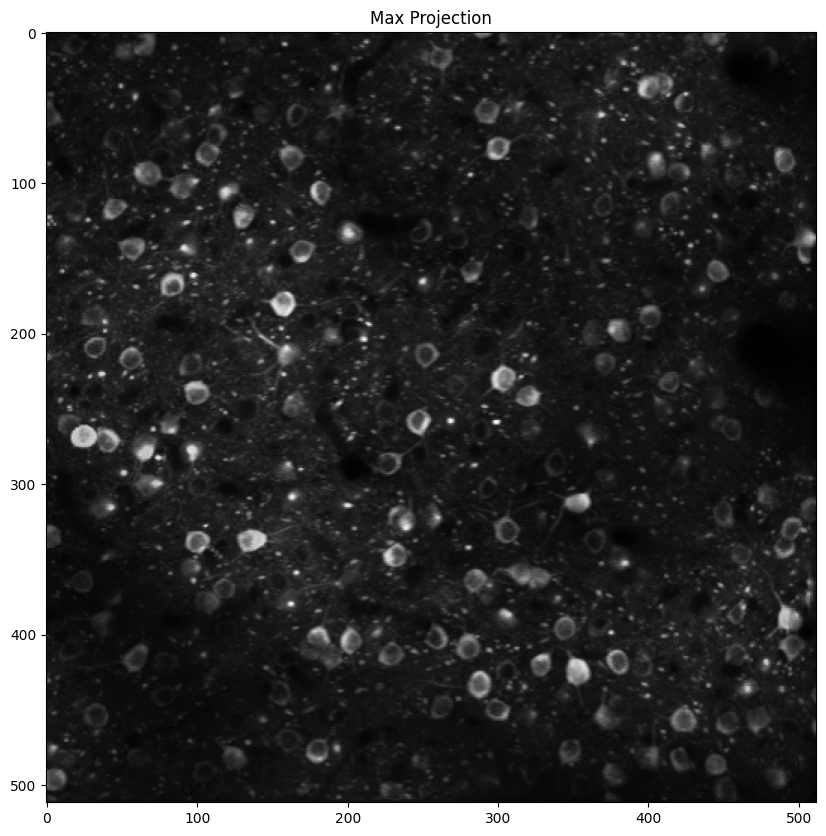

In [ ]:
# what is max projection?
max_projection = data["max_projection"]
print("max_projection min: ", np.min(max_projection))
print("max_projection max: ", np.max(max_projection))

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.imshow(max_projection, cmap="gray")
axs.set_title("Max Projection")
plt.show()

# NOTE this is the image of the brain slice

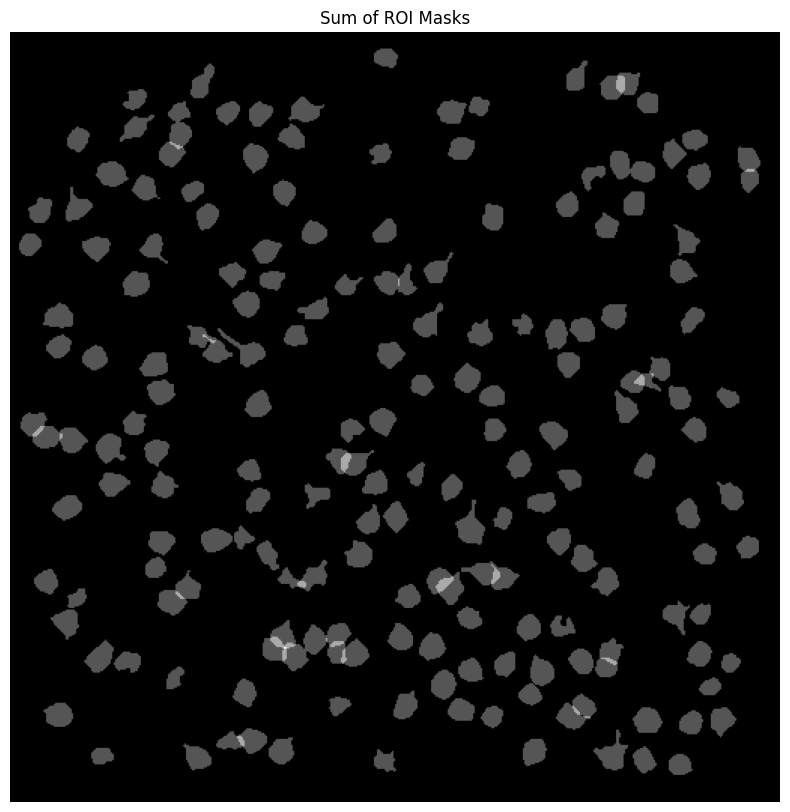

In [ ]:
# cumulation of the ROI masks?
# lets do this manually. Add all masks together, normalize and plot
roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.imshow(roi_masks_sum, cmap="gray")
axs.set_title("Sum of ROI Masks")
axs.axis("off")
plt.show()

stim shape:  (9000, 16, 28)
stim[0] min:  0
stim[0] max:  255
stim[0] median:  127.0


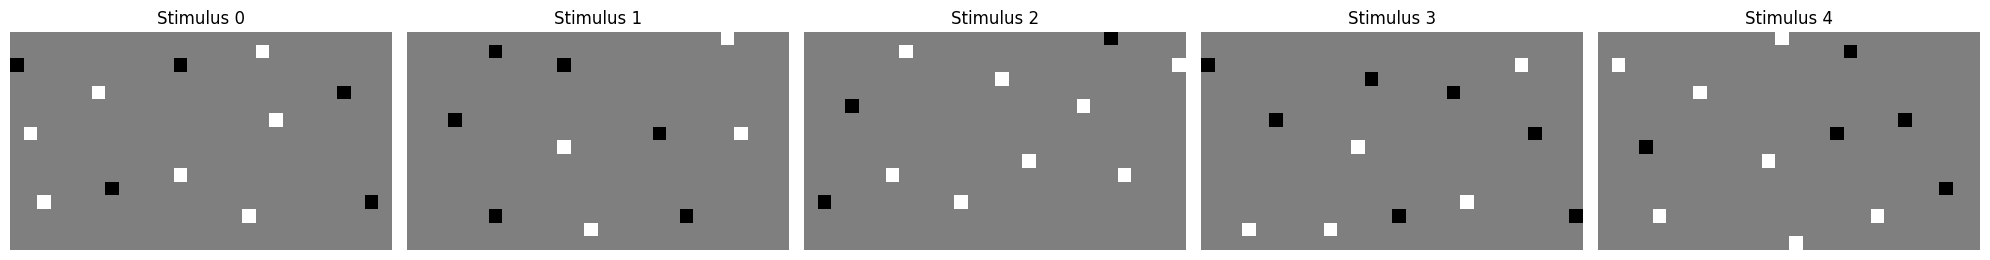

In [ ]:
# lets have a look at the stimuli
stim = data["stim"]
print("stim shape: ", stim.shape)  # NOTE appears to be images
print("stim[0] min: ", np.min(stim[0]))
print("stim[0] max: ", np.max(stim[0]))
print("stim[0] median: ", np.median(stim[0]))
# NOTE stimuli are 0 and 255, no stimulus is 127, i.e. gray

# plot the first 5 stimuli
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(stim[i], cmap="gray")
    axs[i].set_title(f"Stimulus {i}")
    axs[i].axis("off")
fig.tight_layout()
plt.show()

In [ ]:
# what is stim_table?
stim_table = data["stim_table"]
print("stim_table type: ", type(stim_table))
print("stim_table shape: ", stim_table.shape)
print("stim_table head:\n", stim_table.head())
print("stim_table tail:\n", stim_table.tail())

# NOTE The table has a frame, start and end column. It is the frame number of the stimuli (but 8880 does not match the number of stimuli)
# start and end are indices of the time points in t where the stimulus starts and ends

stim_table type:  <class 'pandas.core.frame.DataFrame'>
stim_table shape:  (8880, 3)
stim_table head:
    frame  start  end
0      0    737  744
1      1    745  752
2      2    752  759
3      3    760  767
4      4    767  774
stim_table tail:
       frame   start     end
8875   8875  105705  105712
8876   8876  105712  105719
8877   8877  105720  105727
8878   8878  105727  105734
8879   8879  105735  105742


In [ ]:
# is the time in t between two entries always the same?
min_diff = np.min(np.diff(t))
max_diff = np.max(np.diff(t))
print("min time difference: ", min_diff, "s")
print("max time difference: ", max_diff, "s")

# time between stimuli
print(
    "time one frame (0) is shown: ",
    t[stim_table["end"].iloc[0]] - t[stim_table["start"].iloc[0]],
    "s",
)

# time between end of frame 0 and start of frame 1
print("end frame 0 at ", t[stim_table["end"].iloc[0]], "s")
print("start frame 1 at ", t[stim_table["start"].iloc[1]], "s")
print(
    "time between end of frame 0 and start of frame 1: ",
    t[stim_table["start"].iloc[1]] - t[stim_table["end"].iloc[0]],
    "s",
)

# duration frame 1 is shown
print(
    "time frame (1) is shown: ",
    t[stim_table["end"].iloc[1]] - t[stim_table["start"].iloc[1]],
    "s",
)

# find time intervals in sim_table where the difference between end of frame n and start of the next frame n+1 is greater than 1
time_intervals = []
for i in range(stim_table.shape[0] - 1):
    if stim_table["start"].iloc[i + 1] - stim_table["end"].iloc[i] > 1:
        time_intervals.append(
            (stim_table["end"].iloc[i], stim_table["start"].iloc[i + 1])
        )
print("time intervals: ", time_intervals)

# NOTE each frame is shown for ca. 230 ms.

# is there any stimulus image, that is just gray?
gray_stimuli_idx = []
for i in range(stim.shape[0]):
    if np.var(stim[i]) < 0.001:
        print("gray stimuli indices: ", gray_stimuli_idx)

min time difference:  0.03316999999969994 s
max time difference:  0.03318000000035681 s
time one frame (0) is shown:  0.23219999999999885 s
end frame 0 at  34.00992 s
start frame 1 at  34.04309 s
time between end of frame 0 and start of frame 1:  0.03316999999999837 s
time frame (1) is shown:  0.23221000000000203 s
time intervals:  [(22461, 41476), (63199, 82208)]


In [ ]:
# what is stim_epoch_table?
stim_epoch_table = data["stim_epoch_table"]
print("stim_epoch_table type: ", type(stim_epoch_table))
print("stim_epoch_table shape: ", stim_epoch_table.shape)
print("stim_epoch_table:\n", stim_epoch_table)
# NOTE the first column is the stimulus type, the second and third are the start and end indices of the time points in t

stim_epoch_table type:  <class 'pandas.core.frame.DataFrame'>
stim_epoch_table shape:  (7, 3)
stim_epoch_table:
                stimulus  start     end
0  locally_sparse_noise    737   22461
1           spontaneous  22611   31520
2     natural_movie_one  31521   40571
3  locally_sparse_noise  41476   63199
4     natural_movie_two  64105   73156
5           spontaneous  73306   82207
6  locally_sparse_noise  82208  105742


In [ ]:
# lets have a look at the natural_movie_two stimulus at timepoint 31521
# find the frame number in stim_table where start <= 31521 and end > 31521
frame = stim_table[(stim_table["start"] <= 31521) & (stim_table["end"] > 31521)][
    "frame"
]
print("frame: ", frame)  # NOTE oooh, there is none...now i understand!

# just double check with spontaneuous stimulus at timepoint 22611
frame = stim_table[(stim_table["start"] <= 22611) & (stim_table["end"] > 22611)][
    "frame"
]
print("frame: ", frame)  # NOTE here nothing as well

frame:  Series([], Name: frame, dtype: int64)
frame:  Series([], Name: frame, dtype: int64)


#### Was wir wissen:
In dem Experiment wurden Mäusen verschiedene Stimuli gezeigt, darunter Filme und **locally sparse noise**, die wir hier behandeln. Das heißt erst einmal, dass wir die **Zeiträume in denen ein anderer Stimulus gezeigt wird rausschneiden müssen**.

- `t` sind wieder Zeitpunkte in s
- `dff` ist die cell activity, die sieht nicht gefiltert aus und es gibt eine Messung pro Zelle pro Zeitpunkt `t`
- `stim` sind die **locally sparse noise** stimuli. Also graue Bilder mit weißen und schwarzen Punkten.
- `stim_epoch_table` gibt die Zeiträume an in welchenen welcher Stimulus gezeigt wurde. Die "Zeiten" sind Indexe in `t`
- `stim_table` gibt an zu welchen Zeiten in `t` (wieder als Index) welcher Frame aus `stim` gezeigt wird. Hier werden weniger Stimuli gezeigt als vorhanden. Die Zeiten liegen in den locally sparse noise Zeiträumen aus `stim_epoch_table`
- `roi_masks` sind Bilder bestehend aus 0 und 1, die die Region angeben, in der eine Zelle aktiv ist? Das kann ich nicht genau beurteilen.
- `max_projection` ist ein Bild, das wie ein Bild von dem Brain Tissue Slice aussieht.
- `running_speed` beinhaltet **nicht die Pupillenweite**. Die zweite Dimension ist basically nochmal `t`. In den speed Daten sind viele NaNs!

locally_sparse_noise:
                stimulus  start     end
0  locally_sparse_noise    737   22461
3  locally_sparse_noise  41476   63199
6  locally_sparse_noise  82208  105742


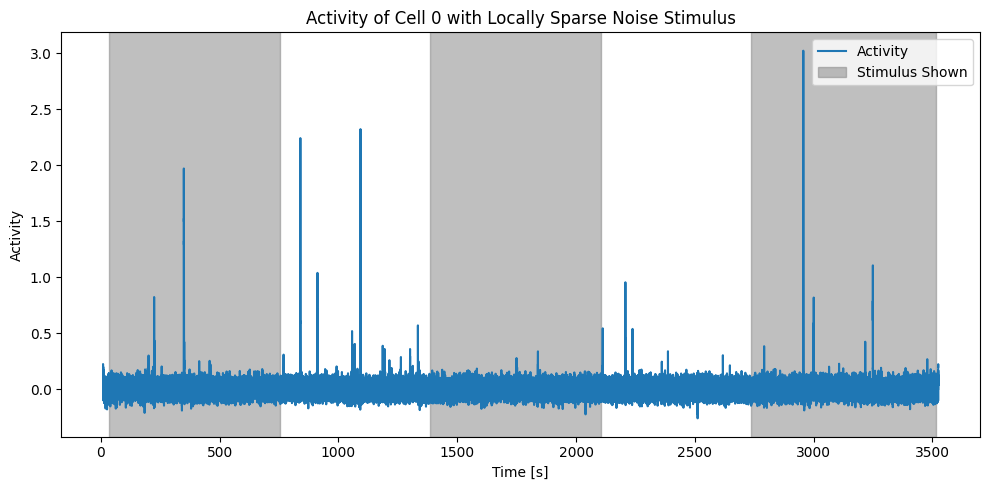

In [ ]:
# plot the activity of cell 0 and mark the epochs where the locally sparse noise stimulus is shown

# get table entries from stim_epoch_table where stimulus is locally sparse noise
locally_sparse_noise = stim_epoch_table[
    stim_epoch_table["stimulus"] == "locally_sparse_noise"
]
print("locally_sparse_noise:\n", locally_sparse_noise)

# plot the activity of cell 0
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(t, dff[0], label="Activity")

# mark the epochs where the locally sparse noise stimulus is shown
for i in range(locally_sparse_noise.shape[0]):
    start = locally_sparse_noise.iloc[i]["start"]
    end = locally_sparse_noise.iloc[i]["end"]
    if i == 0:
        axs.axvspan(t[start], t[end], color="gray", alpha=0.5, label="Stimulus Shown")
    else:
        axs.axvspan(t[start], t[end], color="gray", alpha=0.5)

axs.set_title("Activity of Cell 0 with Locally Sparse Noise Stimulus")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Activity")
plt.legend()
fig.tight_layout()
plt.show()

In [ ]:
from scipy import signal


def butter_filter_signal(
    x: np.array, fs: float, low: float, high: float, order: int = 3
) -> np.array:
    """Filter raw signal x.
    Parameters
    ----------
    x: np.array, (n_samples, n_cells)
        Each column in x is one cell.
    fs: float
        Sampling frequency.
    low, high: float, float
        Passband in Hz for the butterworth filter.
    order: int
        The order of the Butterworth filter. Default 3

    Returns
    -------
    y: np.array, (n_samples, n_cells)
    The filtered x. The filter delay is compensated in the output y.
    """

    y = np.apply_along_axis(
        lambda col: signal.sosfiltfilt(  # apply the filter to all columns
            signal.butter(  # apply the filter to a column
                N=order,
                Wn=[low, high],  # frequency thresholds (normalized)
                btype="band",  # filter type
                analog=False,
                output="sos",  # second-order sections
            ),
            col,
        ),
        axis=1,
        arr=x,
    )

    return y


def wiener_filter_signal(x: np.array, window: float) -> np.array:
    """Apply Wiener Filter to raw signal x.
    Parameters
    ----------
    x: np.array, (n_samples, n_cells)
        Each column in x is one cell.
    window: float, float
        size of the wiener filter

    Returns
    -------
    y: np.ndarray, (n_samples, n_cells)
        The filtered x. There is no filter delay as to my knowledge
    """

    y = np.apply_along_axis(
        lambda col: signal.wiener(  # apply the filter to a column
            col,
            mysize=window,  # window of the wiener filter
        ),
        axis=1,
        arr=x,
    )

    return y

In [ ]:
fs = 1 / (
    t[2] - t[1]
)  # TODO: wie sicher sind wir uns dass die Zeitangaben s und nicht ms sind? Weil mit s hätten wir eine sampling frequency von 30 Hz?
dt = 1 / fs

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

# NOTE: mit diesen Parametern kann man dann auch noch rumspielen...
# Bandwith of the butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (
    fs / 2
)  # in coding lab 1 hatten wir auch den butterworth mit 10teln der orignalen frequency!

window_wiener = 10

dff_butter = butter_filter_signal(x=dff, fs=fs, low=low, high=high, order=4)
dff_wiener = wiener_filter_signal(x=dff, window=window_wiener)
dff_both = wiener_filter_signal(x=dff_butter, window=window_wiener)

# NOTE: wenn man hier ein bisschen rumspielt sieht man dass beide Filter nacheinander angewandt das schönste Ergebnis liefern;
# Aber bitte gerne selbst rumprobieren und zum eigenen Ergebnis kommen

Sampling frequency is 30.14772384684943 Hz, Time Interval is 0.033170000000000144 s


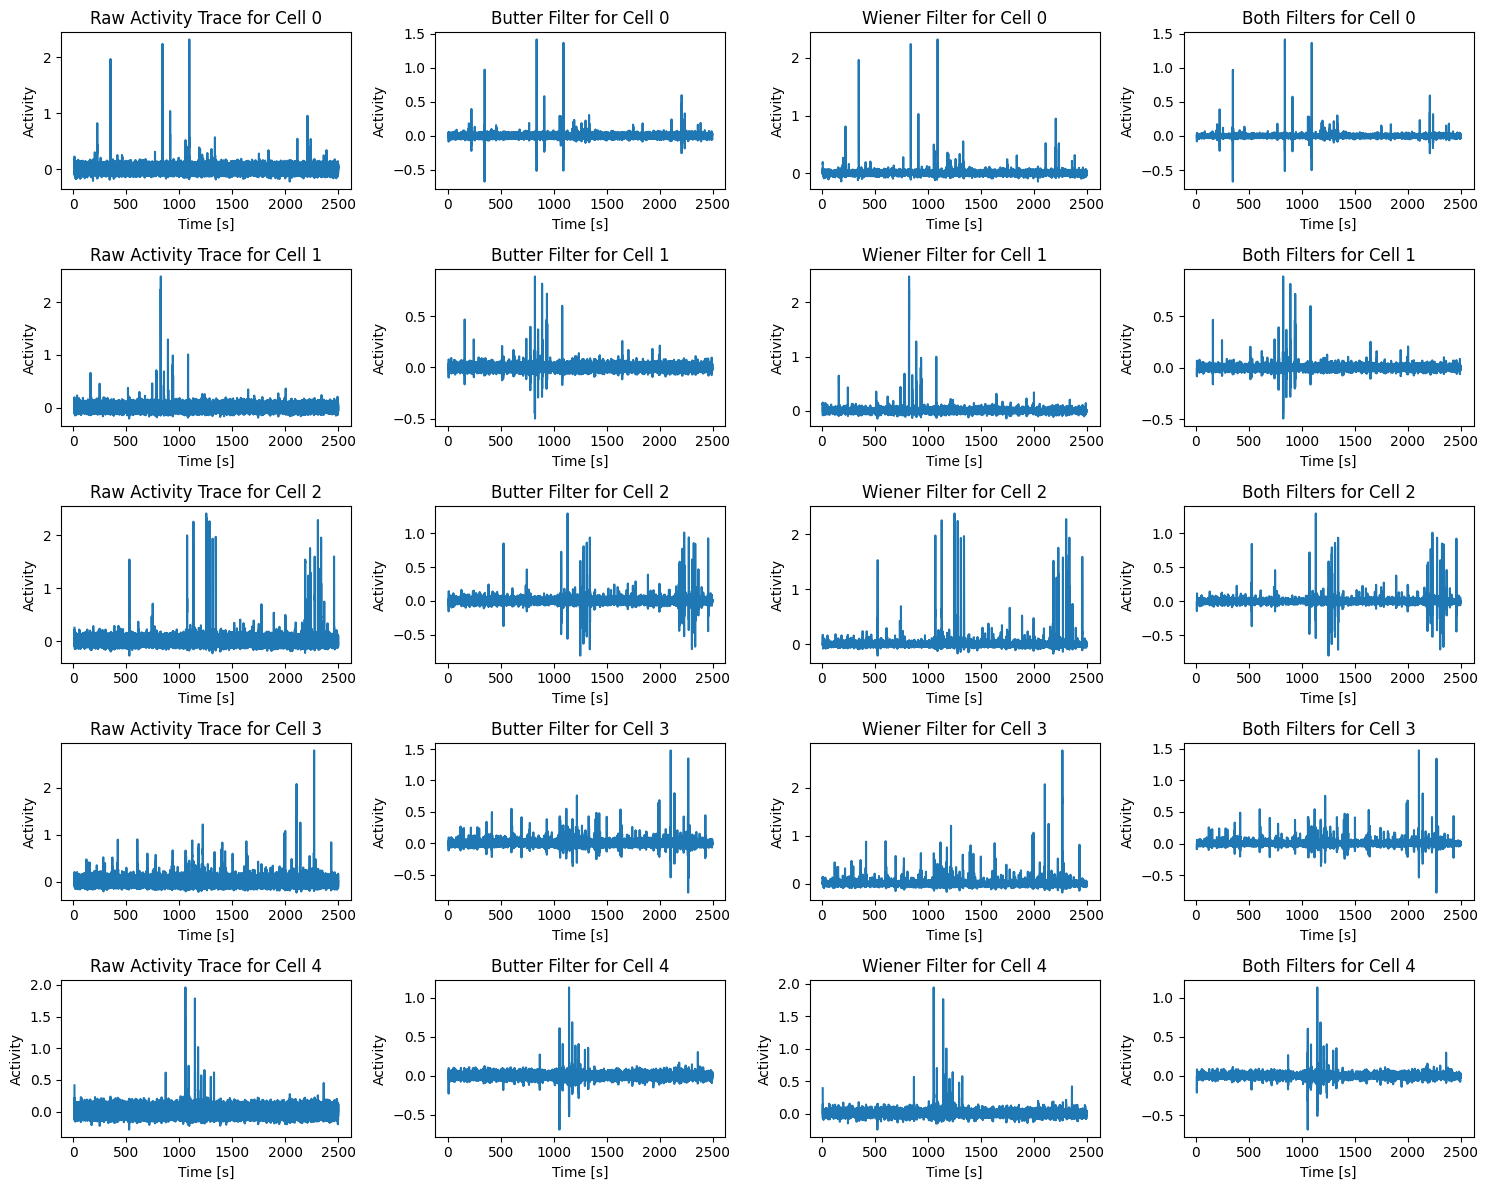

In [ ]:
t_max = 75000  # TODO: hier mal bissi mit dem t_max rumspielen um die Unterschiede zu sehen (100, 750, 7500 75000 sind sinnvolle Werte)
# print a activity trace for the first 5 cells
fig, axs = plt.subplots(5, 4, figsize=(15, 12))
for i in range(5):
    # Plot the non-filtered signal
    axs[i, 0].plot(t[0:t_max], dff[i][0:t_max], label="Non-Filtered")
    axs[i, 0].set_title(f"Raw Activity Trace for Cell {i}")
    axs[i, 0].set_xlabel("Time [s]")
    axs[i, 0].set_ylabel("Activity")

    # Plot the filtered signal
    axs[i, 1].plot(t[0:t_max], dff_butter[i][0:t_max])
    axs[i, 1].set_title(f"Butter Filter for Cell {i}")
    axs[i, 1].set_xlabel("Time [s]")
    axs[i, 1].set_ylabel("Activity")

    # Plot the non-filtered signal
    axs[i, 2].plot(t[0:t_max], dff_wiener[i][0:t_max])
    axs[i, 2].set_title(f"Wiener Filter for Cell {i}")
    axs[i, 2].set_xlabel("Time [s]")
    axs[i, 2].set_ylabel("Activity")

    axs[i, 3].plot(t[0:t_max], dff_both[i][0:t_max])
    axs[i, 3].set_title(f"Both Filters for Cell {i}")
    axs[i, 3].set_xlabel("Time [s]")
    axs[i, 3].set_ylabel("Activity")

plt.tight_layout()
plt.show()

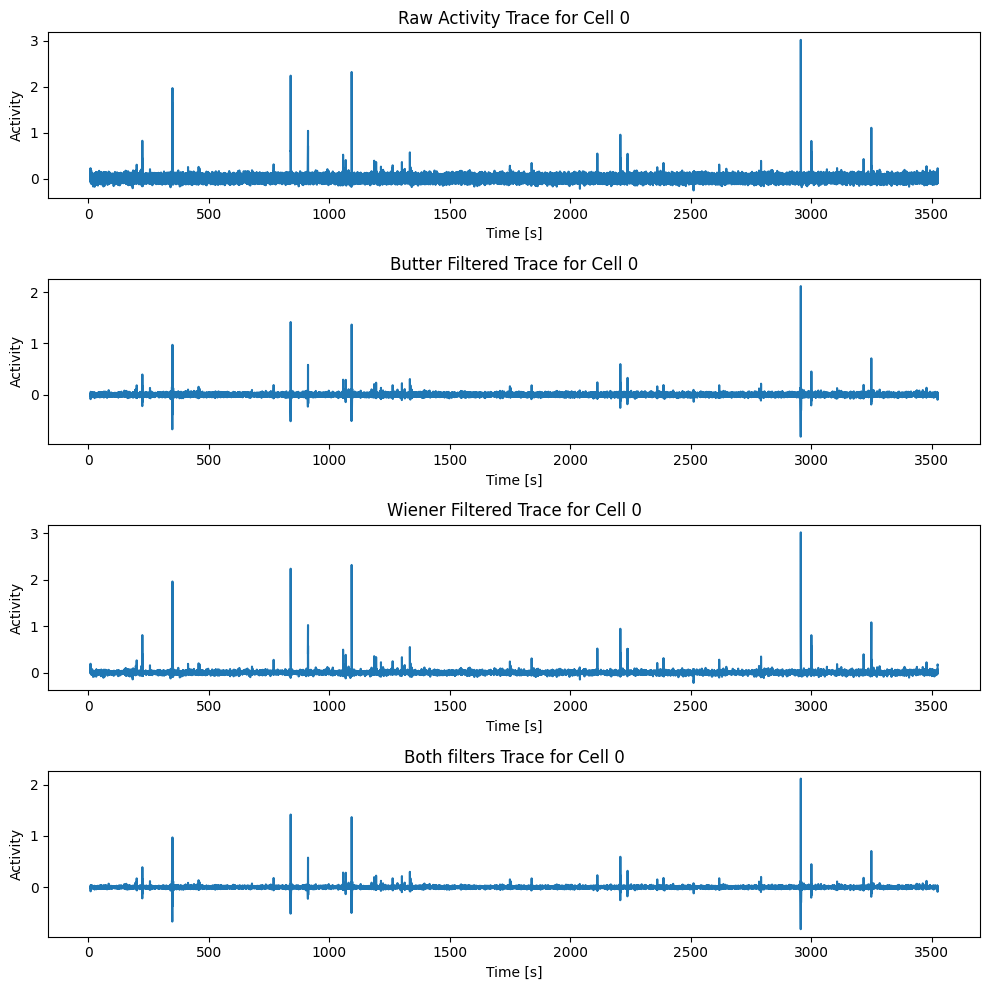

In [ ]:
# print a activity trace for the first 2 cells;
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

axs[0].plot(t, dff[0])
axs[0].set_title(f"Raw Activity Trace for Cell 0")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Activity")

axs[1].plot(t, dff_butter[0])
axs[1].set_title(f"Butter Filtered Trace for Cell 0")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Activity")

axs[2].plot(t, dff_wiener[0])
axs[2].set_title(f"Wiener Filtered Trace for Cell 0")
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel("Activity")

axs[3].plot(t, dff_both[0])
axs[3].set_title(f"Both filters Trace for Cell 0")
axs[3].set_xlabel("Time [s]")
axs[3].set_ylabel("Activity")

plt.tight_layout()
plt.show()

In [ ]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py

--2024-07-19 13:41:08--  https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7973 (7.8K) [text/plain]
Saving to: ‘oopsi.py.4’

oopsi.py.4          100%[===================>]   7.79K  --.-KB/s    in 0s      

2024-07-19 13:41:08 (83.8 MB/s) - ‘oopsi.py.4’ saved [7973/7973]



In [ ]:
import oopsi

# Hier am besten einfach mal alle 3 arrays einsetzen und schauen wie sich die Prediction verändert

oopsi_ogb = oopsi.fast(dff_both[0], dt=(t[2] - t[1]))
spike_train = [
    1 if value > 0.03 else 0 for value in oopsi_ogb[0]
]  # hier muss man glaube ich den threshold anpassen... 0.1 ist recht konservativ, 0.01 viel zu liberal

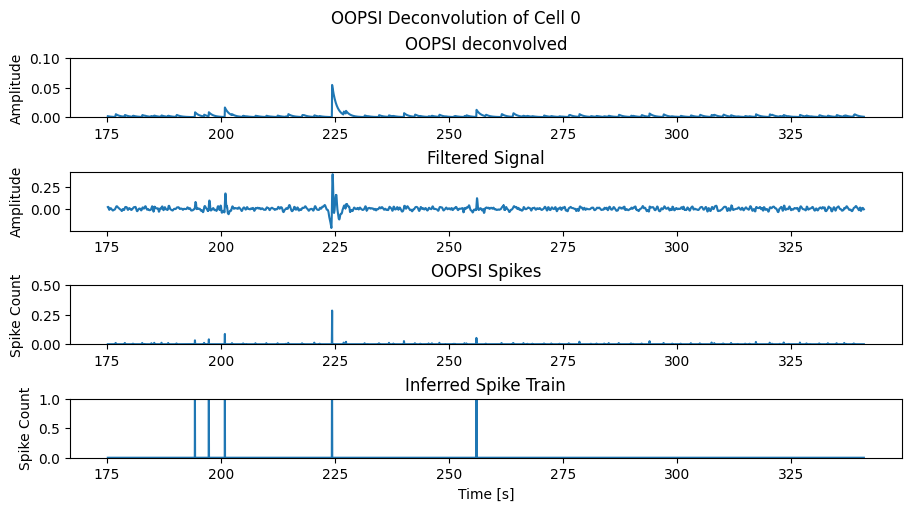

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(9, 5), layout="constrained")
# das ist ein sinnvolles Zeitintervall aber kann man natürlich ändern wenn man möchte :)
t_min = 5000
t_max = 10000

axs[0].plot(t[t_min:t_max], oopsi_ogb[1][t_min:t_max])
axs[0].set_title("OOPSI deconvolved")
axs[0].set_ylim(0, 0.1)
axs[0].set_ylabel("Amplitude")

# NOTE: hier auch array ändern :)
axs[1].plot(t[t_min:t_max], dff_both[0][t_min:t_max])
axs[1].set_title("Filtered Signal")
axs[1].set_ylabel("Amplitude")

axs[2].plot(t[t_min:t_max], oopsi_ogb[0][t_min:t_max])
axs[2].set_title("OOPSI Spikes")
axs[2].set_ylim(0, 0.5)
axs[2].set_ylabel("Spike Count")

axs[3].plot(t[t_min:t_max], spike_train[t_min:t_max])
axs[3].set_title("Inferred Spike Train")
axs[3].set_ylim(0, 1)
axs[3].set_ylabel("Spike Count")


plt.xlabel("Time [s]")
plt.suptitle("OOPSI Deconvolution of Cell 0")

plt.show()

In [ ]:
# TODO: jetzt müsste man noch das oopsie auf alle Zellen anwenden :)

### Zweites Thema: Preprocessing + und Spike Detection
Ich meine man sollte preprocessing abhänig davon machen, welchen Detection Algorithmus man verwenden will.

Hier einige Gedanken aus den bisherigen Notbooks/ Vorlesungen:
- Wir haben erst gefiltert und dann die spike trains inferiert; da es sich hier um Calcium Daten handelt sollten wir vermutlich dem in VL 3 vorgeschlagenen Paper von Yaksi & Friedrich folgen; die machen Filtering und Deconvolution der neuronalen Aktivität

Yaksi, E., Friedrich, R. Reconstruction of firing rate changes across neuronal populations by temporally deconvolved Ca2+ imaging. Nat Methods 3, 377–383 (2006). https://doi.org/10.1038/nmeth874

Hier grob die Schritte, die man gehen könnte; 1 und 2 haben wir damals im Notebook geskippt! (war nicht Aufgabe) --> Das ist das Preprocessing, das wir dieses mal machen müssen!
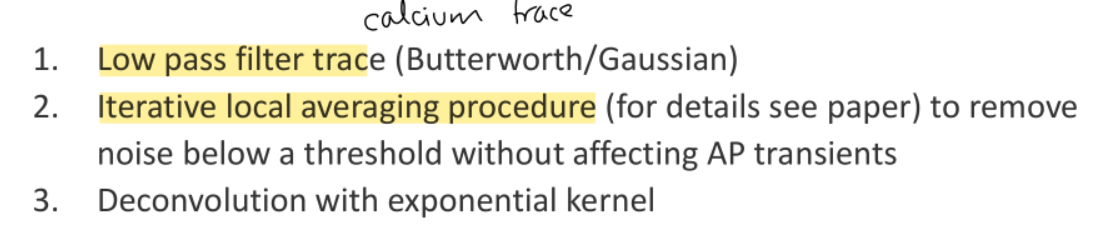


Für die Deconvolution an sich kann man sich dann überlegen, welchen Algorithmus man verwenden will; entweder man macht nur einen einfach Kernel oder man versucht dieses oopsi ODER einen der anderen Algorithmen, die vorgestellt wurden; wir hatten damals nur oopsi implementiert. Da wir keine Ground Truth Daten haben kann man die Algorithmen nicht wirklich sinnvoll statistisch vergleichen...
TODO: Hier eine Entscheidungsmöglichkeit finden.


Schritte im Preprocessing:

1. First Low pass filter; Butterworth or Gaussian (Das sagen die im Paper nicht genau, sie sagen "or") --> CL 1, Aufgabe 1: 
"low-pass Butterworth or Gaussian filter with a cutoff frequency minimizing the distortion of sharply rising Ca2+ transients."
"In most cases, we used a 4-pole Butterworth filter with a cutoff frequency equal to 0.2 times the frame rate"

2. further filtered with an algorithm that smoothes peak with ampltiudes below a threshold --> das ist genauer in der PDF 2_iterativeSMoothing beschrieben; muss man glaube ich nicht machen wäre aber sicherlich cool; effektiv identifziert man iterativ den smallest peak in einem Intervall (d.h. nicht den lowest value sondern den smallest peak relativ zu den anderen werten, also den wert des am wenigsten von seinen anderen Werten in Umkreis von x timesteps abweicht! in CL 1 haben wir für eine ähnliche Aufgabe die Funktion scipy.signal.find_peaks verwendet - hier muss man sich nur die Dokumentation nochmal anschauen um die richtigen Peaks zu finden); dann nimmt man den den Peak und macht ein local averaging über die untersuchte Zeitspanne (also wenn wir einen PEak in 10 ms window suchen dan averagen wir auch über diese 10 ms und setzen alle Werte in dem Window auf den average); das ganze dann iterativ wiederholen bis man keien Veränderungen mehr hat (wie auch immer das möglich sein soll) oder bis man max it (5000) erreicht hat; ich denke hier muss man dann im Nachgang noch viel Parameter tweaking machen (wie groß ist das search window, wie viele iterationen?) um gute Ergebnisse zu bekommen; auch hier immer RAW Data mit gesmoothed plotten pls (wenn wir den Schritt machen wollen)

Thema Smoothing: 
- oopsi hat einfach nen wiener filter gemacht, aber im Algorithmus an sich wird nicht nochmal gefiltert; man könnte drüber nachdenken ob wir auch einen Wiener Filter haben wollen? Mein Gedanke dazu: wiener filter ist auch low pass, angepasst an SNR wenn ich das richtig verstehe; mit Butterworth und dem Smoothing erreicht man ja effektiv das gleiche? Weil das Smoothign ist ja auch abh. vom SNR und verbessert dieses, oder?

- c2s ist ein ML Algorithmus; das Preprocessing da ist beschrieben mit: https://github.com/lucastheis/c2s/blob/master/c2s/c2s.py#L166
This [preprocessing] function does three things:
    1. Remove any linear trends using robust linear regression.
    2. Normalize the range of the calcium trace by the 5th and 80th percentile.
    3. Change the sampling rate of the calcium trace and spike train.
Hier ehrlich gesagt keine Ahnung ob wir dann noch preprocessen sollen oder nicht

- OASIS: https://papers.nips.cc/paper_files/paper/2016/hash/fc2c7c47b918d0c2d792a719dfb602ef-Abstract.html; der Algorithmus ist aber wohl eher für Online Processing, was wir ja nicht wollen; gefiltert / gepreprocessed wird hier wohl nichts

Fazit zum Smoothing im Hinblick auf die Spike Inference: Ich denke wir fahren gut wenn wir es implementieren, da es für oopsi und simple deconv auf jeden Fall sinnvoll ist.

In [ ]:
### SMOOTHING #############################
# TODO: Wollen wir das Smoothing machen? So viel Arbeit ist es denke ich nicht oder?

In [ ]:
# samesies mit den plotties - bitte verkünsteln, danke

#### Zweiter Teil vom zweiten Drama: Deconvolution (mit versch. Algorithmen?) & Spike Detection

Hier kann man entweder einfache deconvolution machen mit einem einfachen expoentiellen Kernel ( $y = exp(−t/ \tau$), wie im Yaksi und Friedrich Paper oder man kann fancigere Sachen machen: In CL 3 werden hier diese drei verschiedenen Algorithmen verlinkt

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

Das kommt mMn ein bisschen drauf an, ob man die Algorithmen einfach importieren darf? :D Ansonsten würde ich hier die simple deconv und Oopsie einmal umsetzen, wie im CL 3. Dann die beiden visuell vergleichen und dann argumentieren dass oopsie besser ist und auf die Benchmarking Studie vom Berens (c2s Paper) verweisen, damit begründen warum wir uns für den einen Algorithmus dann entschieden haben. Allerdings müsste man dann fast den c2s von denen nehmen, der ist nähmlich nochmal besser; Hier das Bild dazu (MAP von Vogelstein ist der OOPSI Algorithmus; STM ist der c2s von denen)

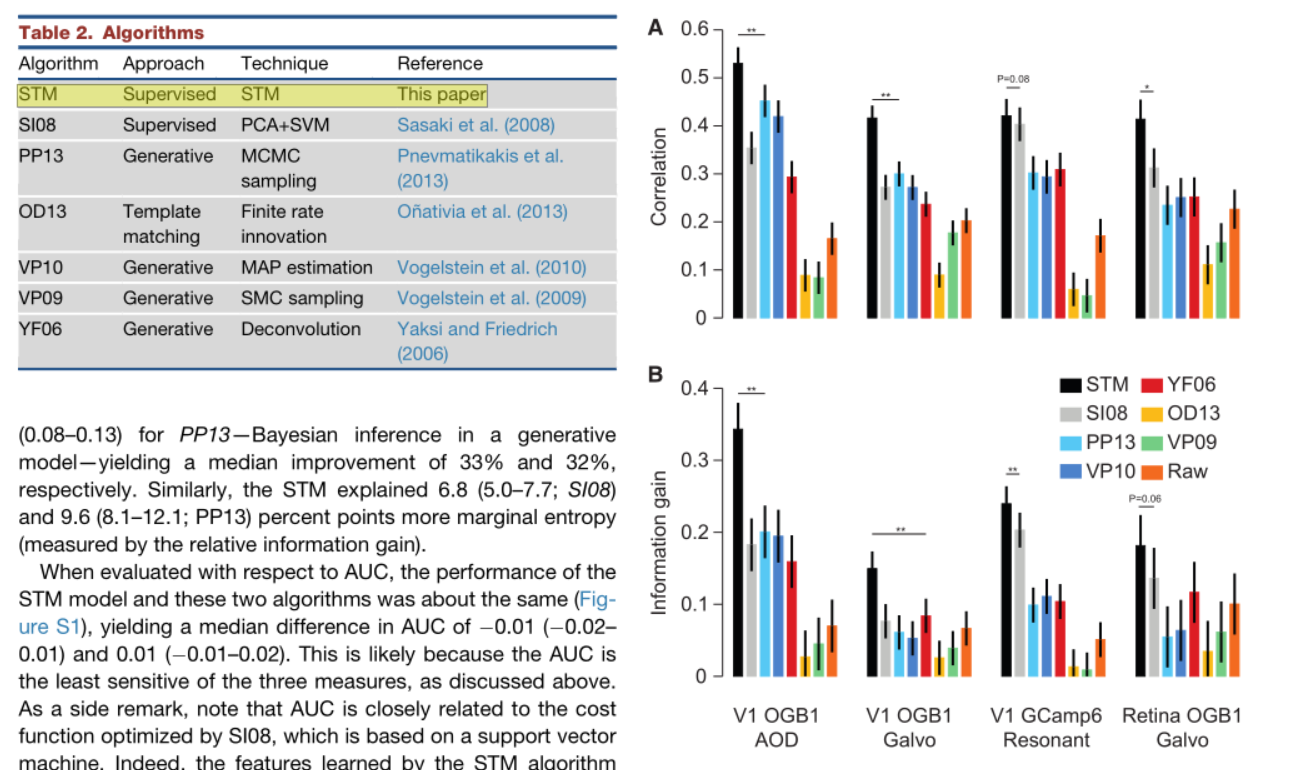


### C2S

In [ ]:
import c2s
import pickle

In [ ]:
1 / (t[-1] / len(t)), 1 / (t[1] - t[0])

(30.065382731147565, 30.14772384684943)

In [ ]:
fps = 1 / (t[-1] / len(t))
data_c2s = []
# fill data with the entries of dff like this {'calcium': [[0., 0., 0., 0.]], 'fps': 10.4}
for i in range(len(dff)):
    data_c2s.append({"calcium": np.array([np.array(dff[i])]), "fps": fps})

In [ ]:
data_preprocessed = c2s.preprocess(data_c2s, verbosity=1)
with open("../data/data_preprocessed.pkl", "wb") as file:
    pickle.dump(data_preprocessed, file)

Preprocessing calcium trace 0...
Preprocessing calcium trace 1...
Preprocessing calcium trace 2...
Preprocessing calcium trace 3...
Preprocessing calcium trace 4...
Preprocessing calcium trace 5...
Preprocessing calcium trace 6...
Preprocessing calcium trace 7...
Preprocessing calcium trace 8...
Preprocessing calcium trace 9...
Preprocessing calcium trace 10...
Preprocessing calcium trace 11...
Preprocessing calcium trace 12...


KeyboardInterrupt: 

In [ ]:
data_preprocessed[0]
# plot the activity of cell 0

{'calcium': array([[2.26530218, 2.46720639, 2.6223644 , ..., 2.32966987, 2.15936165,
         2.13566663]]),
 'fps': 100.00013902345556}

In [ ]:
data_c2s[0]["calcium"][0]

array([0.18523291, 0.22521365, 0.15662627, ..., 0.12980926, 0.22385855,
       0.20101474], dtype=float32)

In [ ]:
data_predicted = c2s.predict(data_preprocessed, verbosity=1)
with open("../data/data_predicted.pkl", "wb") as file:
    pickle.dump(data_predicted, file)

Predicting cell 0...
Predicting cell 1...
Predicting cell 2...
Predicting cell 3...
Predicting cell 4...
Predicting cell 5...
Predicting cell 6...
Predicting cell 7...
Predicting cell 8...
Predicting cell 9...
Predicting cell 10...
Predicting cell 11...
Predicting cell 12...
Predicting cell 13...
Predicting cell 14...
Predicting cell 15...
Predicting cell 16...
Predicting cell 17...
Predicting cell 18...
Predicting cell 19...
Predicting cell 20...
Predicting cell 21...
Predicting cell 22...
Predicting cell 23...
Predicting cell 24...
Predicting cell 25...
Predicting cell 26...
Predicting cell 27...
Predicting cell 28...
Predicting cell 29...
Predicting cell 30...
Predicting cell 31...
Predicting cell 32...
Predicting cell 33...
Predicting cell 34...
Predicting cell 35...
Predicting cell 36...
Predicting cell 37...
Predicting cell 38...
Predicting cell 39...
Predicting cell 40...
Predicting cell 41...
Predicting cell 42...
Predicting cell 43...
Predicting cell 44...
Predicting cell 45..

In [ ]:
data_predicted[1]

{'calcium': array([[2.12742017, 2.52869115, 2.71009211, ..., 1.81748256, 1.64490062,
         1.76105355]]),
 'fps': 100.00013902345556,
 'predictions': array([[0.00724621, 0.00724621, 0.00724621, ..., 0.00724621, 0.00724621,
         0.00724621]])}

In [ ]:
fps

30.065382731147565

In [ ]:
data_preprocessed = pickle.load(open("../data/data_preprocessed.pkl", "rb"))
data_predicted = pickle.load(open("../data/data_predicted.pkl", "rb"))

In [ ]:
data_predicted

[{'calcium': array([[2.26530218, 2.46720639, 2.6223644 , ..., 2.32966987, 2.15936165,
          2.13566663]]),
  'fps': 100.00013902345556,
  'predictions': array([[0.00634519, 0.00634519, 0.00634519, ..., 0.00634519, 0.00634519,
          0.00634519]])},
 {'calcium': array([[2.12742017, 2.52869115, 2.71009211, ..., 1.81748256, 1.64490062,
          1.76105355]]),
  'fps': 100.00013902345556,
  'predictions': array([[0.00724621, 0.00724621, 0.00724621, ..., 0.00724621, 0.00724621,
          0.00724621]])},
 {'calcium': array([[2.68286565, 2.62662603, 2.20074697, ..., 1.58349133, 1.94962285,
          2.39194966]]),
  'fps': 100.00013902345556,
  'predictions': array([[0.00818829, 0.00818829, 0.00818829, ..., 0.00818829, 0.00818829,
          0.00818829]])},
 {'calcium': array([[1.85445343, 2.18596257, 2.31052492, ..., 1.61586546, 1.39415731,
          1.51223486]]),
  'fps': 100.00013902345556,
  'predictions': array([[0.00786747, 0.00786747, 0.00786747, ..., 0.00786747, 0.00786747,
  

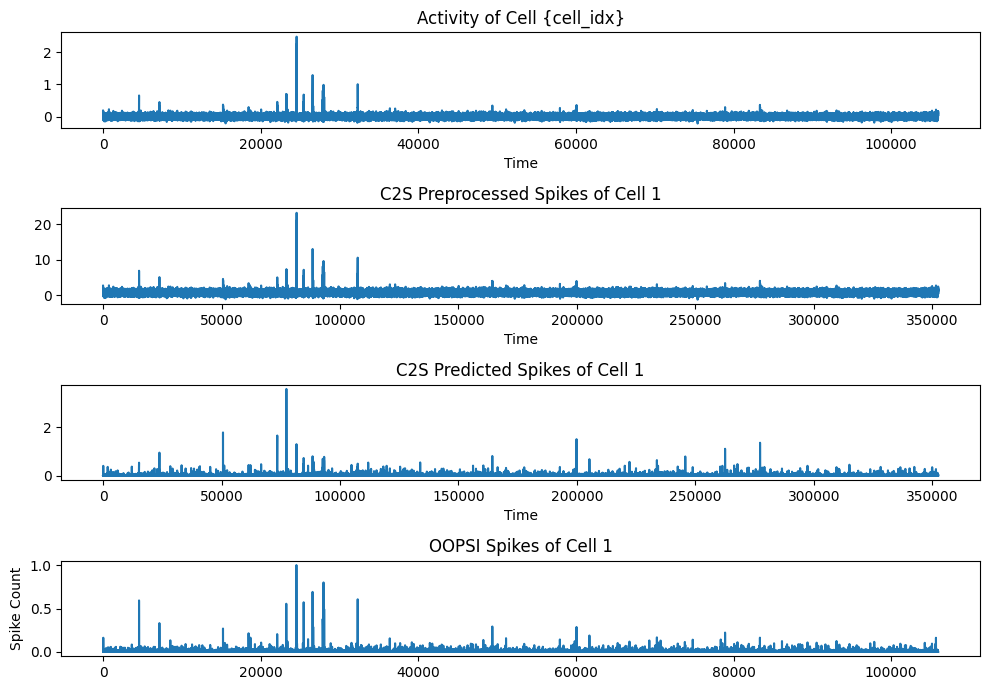

In [ ]:
cell_idx = 1

percent = 0.1

oopsi_ogb = oopsi.fast(dff_both[cell_idx], dt=1 / fps)

fig, axs = plt.subplots(4, 1, figsize=(10, 7))
axs[0].plot(dff[cell_idx][: int(len(dff[cell_idx] * percent))])
axs[0].set_title("Activity of Cell {cell_idx}")
axs[0].set_xlabel("Time")

axs[1].plot(
    data_preprocessed[cell_idx]["calcium"][0][
        : int(len(data_preprocessed[cell_idx]["calcium"][0] * percent))
    ]
)
axs[1].set_title(f"C2S Preprocessed Spikes of Cell {cell_idx}")
axs[1].set_xlabel("Time")

axs[2].plot(
    data_predicted[cell_idx]["predictions"][0][
        : int(len(data_predicted[cell_idx]["predictions"][0] * percent))
    ]
)
axs[2].set_title(f"C2S Predicted Spikes of Cell {cell_idx}")
axs[2].set_xlabel("Time")

axs[3].plot(oopsi_ogb[0][: int(len(oopsi_ogb[0] * percent))])
axs[3].set_title(f"OOPSI Spikes of Cell {cell_idx}")
axs[3].set_ylabel("Spike Count")

plt.tight_layout()
plt.show()

### OASIS

In [ ]:
from oasis.functions import (
    gen_data,
    gen_sinusoidal_data,
    deconvolve,
    estimate_parameters,
)
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

/home/main/uni-tue-nds/Project/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [ ]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20, 4))
    plt.subplot(211)
    plt.plot(b + c, lw=2, label="denoised")
    if groundtruth:
        plt.plot(true_b + true_c, c="r", label="truth", zorder=-11)
    plt.plot(y, label="data", zorder=-12, c="y")
    plt.legend(ncol=3, frameon=False, loc=(0.02, 0.85))
    simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label="deconvolved", c="g")
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k, k], [-0.1, 1], c="r", zorder=-11, clip_on=False)
    plt.ylim(0, 1.3)
    plt.legend(ncol=3, frameon=False, loc=(0.02, 0.85))
    simpleaxis(plt.gca())
    # print(
    #     "Correlation of deconvolved activity  with ground truth ('spikes') : %.4f"
    #     % np.corrcoef(s, true_s)[0, 1]
    # )
    # print(
    #     "Correlation of denoised fluorescence with ground truth ('calcium'): %.4f"
    #     % np.corrcoef(c, true_c)[0, 1]
    # )

[<matplotlib.lines.Line2D>]

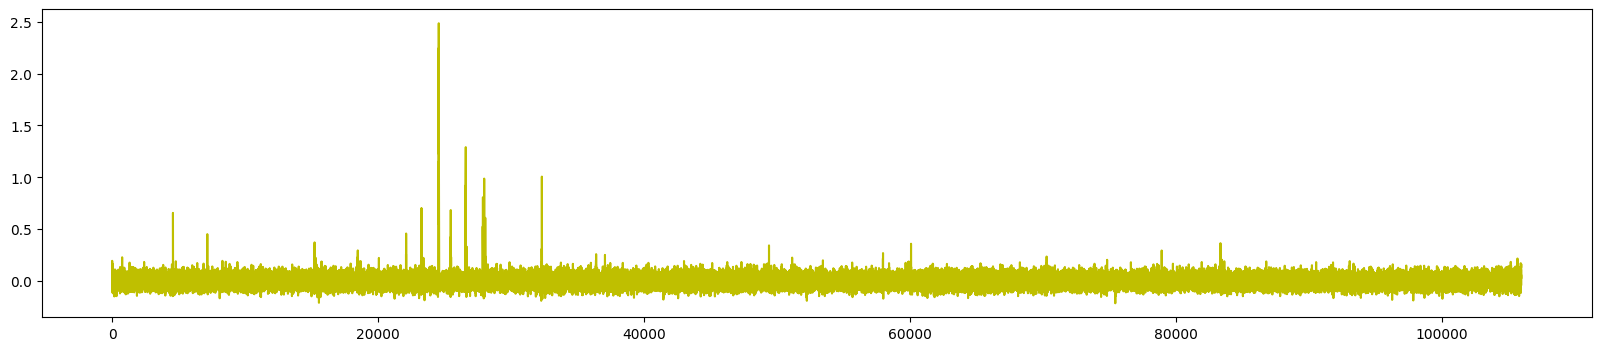

In [ ]:
# here we generate some simulated fluorescence data and plot it
true_b = 1
# y, true_c, true_s = map(np.squeeze, gen_data(N=1, b=true_b, seed=0))
y = dff[1]
plt.figure(figsize=(20, 4))
plt.plot(y, c="y")

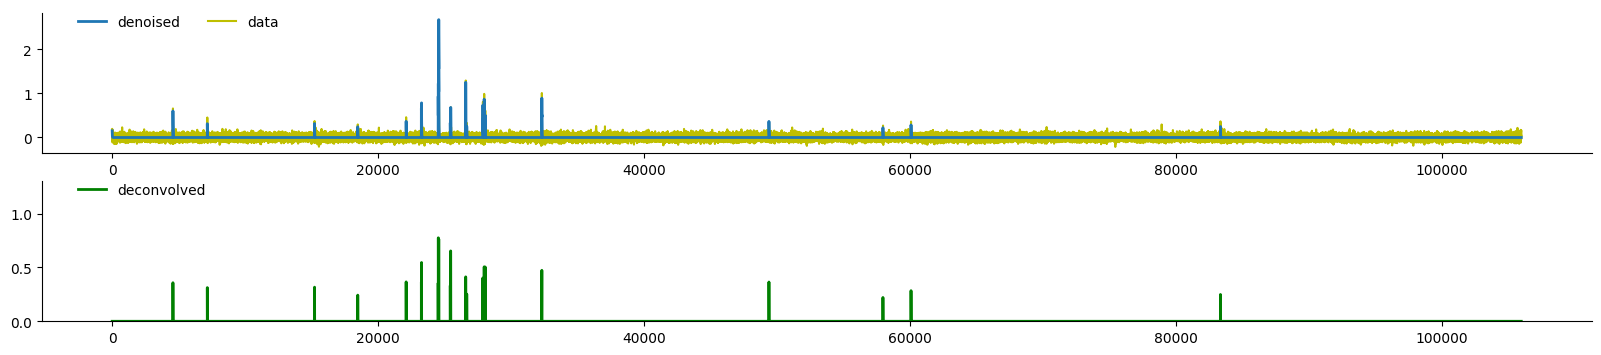

In [ ]:
c, s, b, g, lam = deconvolve(y, penalty=1, optimize_g=5, max_iter=5)
c, s = oasisAR1(y.astype(np.float64), g=g, s_min=0.2)
plot_trace(False)

/home/main/uni-tue-nds/Project/OASIS/oasis/functions.py:171: UserWarning: Optimization of AR parameters is already fairly stable for AR(1), but slower and more experimental for AR(2)
  warn("Optimization of AR parameters is already fairly stable for AR(1), "


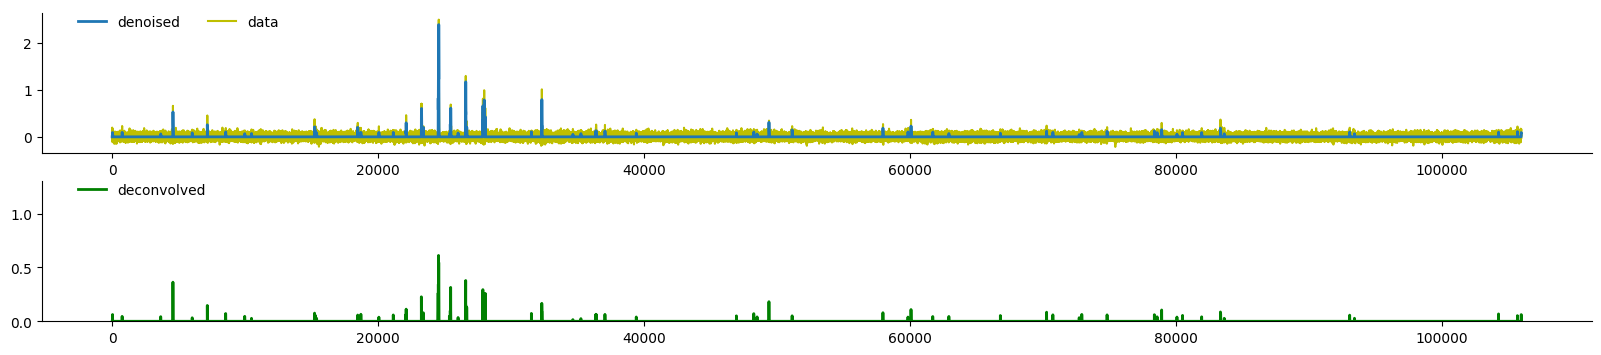

In [ ]:
c, s, b, g, lam = deconvolve(y, g=(None, None), penalty=1, optimize_g=5, max_iter=5)
plot_trace(False)

In [ ]:
cell_idx = 1

percent = 0.1

oopsi_ogb = oopsi.fast(dff_both[cell_idx], dt=1 / fps)

fig, axs = plt.subplots(5, 1, figsize=(10, 7))
axs[0].plot(dff[cell_idx][: int(len(dff[cell_idx] * percent))])
axs[0].set_title("Activity of Cell {cell_idx}")
axs[0].set_xlabel("Time")

axs[1].plot(
    data_preprocessed[cell_idx]["calcium"][0][
        : int(len(data_preprocessed[cell_idx]["calcium"][0] * percent))
    ]
)
axs[1].set_title(f"C2S Preprocessed Spikes of Cell {cell_idx}")
axs[1].set_xlabel("Time")

axs[2].plot(
    data_predicted[cell_idx]["predictions"][0][
        : int(len(data_predicted[cell_idx]["predictions"][0] * percent))
    ]
)
axs[2].set_title(f"C2S Predicted Spikes of Cell {cell_idx}")
axs[2].set_xlabel("Time")

axs[3].plot(oopsi_ogb[0][: int(len(oopsi_ogb[0] * percent))])
axs[3].set_title(f"OOPSI Spikes of Cell {cell_idx}")
axs[3].set_ylabel("Spike Count")

axs[4].plot(s[: int(len(s) * percent)])
axs[4].set_title(f"OOPSI Spikes of Cell {cell_idx}")
axs[4].set_ylabel("Spike Count")

plt.tight_layout()
plt.show()